In [1]:
# CELL 1: ROBUST PREPROCESSING WITH ERROR HANDLING
import numpy as np
import os
from scipy import signal
import traceback

def safe_np_load(file_path):
    """Safely load .npz files with error handling"""
    try:
        data = np.load(file_path)
        return data, True
    except Exception as e:
        print(f"❌ Failed to load {file_path}: {e}")
        return None, False

def preprocess_eeg_data(data, fs=256, window_size=1, overlap=0):
    """
    Preprocess EEG data by applying segmentation and windowing
    """
    # Ensure data is 3D: (samples, channels, timepoints)
    if data.ndim == 2:
        data = data.reshape(data.shape[0], 1, data.shape[1])
    
    n_samples, n_channels, n_timepoints = data.shape
    
    # Adjust window size to not exceed signal length
    window_samples = min(int(window_size * fs), n_timepoints)
    step_samples = int(window_samples * (1 - overlap))
    
    print(f"Original data shape: {data.shape}")
    print(f"Window size: {window_size}s ({window_samples} samples)")
    print(f"Step size: {step_samples} samples")
    print(f"Overlap: {overlap*100}%")
    
    # Calculate number of windows per sample
    n_windows_per_sample = max(1, (n_timepoints - window_samples) // step_samples + 1)
    total_windows = n_samples * n_windows_per_sample
    
    # Initialize output array
    processed_data = np.zeros((total_windows, n_channels, window_samples))
    
    print(f"Creating {n_windows_per_sample} windows per sample")
    print(f"Total windows: {total_windows}")
    
    # Apply windowing to each sample
    window_idx = 0
    for sample_idx in range(n_samples):
        for window_start in range(0, n_timepoints - window_samples + 1, step_samples):
            window_end = window_start + window_samples
            processed_data[window_idx] = data[sample_idx, :, window_start:window_end]
            window_idx += 1
    
    print(f"Final processed data shape: {processed_data.shape}")
    return processed_data

def preprocess_single_file(file_path, window_size=1, overlap=0):
    """
    Preprocess a single file with comprehensive error handling
    """
    print(f"\n{'='*50}")
    print(f"Preprocessing: {os.path.basename(file_path)}")
    print(f"{'='*50}")
    
    # Try to load the file
    original_data, success = safe_np_load(file_path)
    if not success:
        return False
    
    keys = list(original_data.keys())
    print(f"Original keys: {keys}")
    
    # Identify data and label keys
    data_key = None
    label_key = None
    
    # Common key patterns
    data_patterns = ['x', 'train_signals', 'signals', 'data', 'eeg', 'X']
    label_patterns = ['y', 'train_labels', 'labels', 'target', 'Y']
    
    for key in keys:
        key_lower = key.lower()
        if any(pattern in key_lower for pattern in data_patterns):
            data_key = key
        elif any(pattern in key_lower for pattern in label_patterns):
            label_key = key
    
    if data_key is None:
        data_key = keys[0]  # Use first key as fallback
    
    try:
        # Extract data
        eeg_data = original_data[data_key]
        print(f"Original EEG data shape: {eeg_data.shape}")
        
        # Extract labels if available
        if label_key and label_key in keys:
            original_labels = original_data[label_key]
            print(f"Original labels shape: {original_labels.shape}")
        else:
            original_labels = None
            print("No labels found in file")
        
        # Apply preprocessing
        processed_eeg = preprocess_eeg_data(eeg_data, window_size=window_size, overlap=overlap)
        
        # Handle labels
        if original_labels is not None:
            n_windows_per_sample = processed_eeg.shape[0] // eeg_data.shape[0]
            processed_labels = np.repeat(original_labels, n_windows_per_sample)
            print(f"Processed labels shape: {processed_labels.shape}")
        else:
            processed_labels = None
        
        # Save processed data
        output_path = file_path.replace('.npz', '_preprocessed.npz').replace("../data/raw/", "../data/processed/mit_chb/")
        save_dict = {'x': processed_eeg}
        if processed_labels is not None:
            save_dict['y'] = processed_labels
        
        # Add metadata
        save_dict['feature_names'] = [f'channel_{i}' for i in range(processed_eeg.shape[1])]
        save_dict['preprocessing_info'] = f'window_{window_size}s_overlap_{overlap}'
        
        np.savez(output_path, **save_dict)
        print(f"✅ Saved to: {output_path}")
        return True
        
    except Exception as e:
        print(f"❌ Error during preprocessing: {e}")
        traceback.print_exc()
        return False

def check_file_sizes(file_list, base_path=""):
    """Check if files exist and their sizes"""
    print("Checking files...")
    valid_files = []
    
    for file_name in file_list:
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
            print(f"  ✓ {file_name} ({file_size:.1f} MB)")
            valid_files.append(file_name)
        else:
            print(f"  ✗ {file_name} (File not found)")
    
    return valid_files

print("Robust preprocessing functions loaded!")

Robust preprocessing functions loaded!


In [2]:
# CELL 2: CHECK FILES AND PREPROCESS ONE BY ONE
# List all your original EEG files
all_original_files = [
    "eeg-seizure_train.npz",
    "eeg-seizure_val.npz", 
    "eeg-seizure_test.npz",
    "eeg-seizure_val_balanced.npz",
    "eeg-predictive_train.npz",
    "eeg-predictive_val.npz",
    "eeg-predictive_val_balanced.npz"
]

print("Step 1: Checking files...")
valid_files = check_file_sizes(all_original_files, base_path="../data/raw/")

print(f"\nStep 2: Preprocessing {len(valid_files)} valid files...")
print("Using 1-second windows (no overlap)\n")

success_count = 0
for file_name in valid_files:
    file_path = os.path.join("../data/raw/", file_name)
    if preprocess_single_file(file_path, window_size=1, overlap=0):
        success_count += 1
    print()  # Empty line for readability

print(f"\nPreprocessing Summary:")
print(f"Successfully processed: {success_count}/{len(valid_files)} files")
print(f"Failed: {len(valid_files) - success_count} files")

if success_count > 0:
    print("\nGenerated files:")
    for file_name in valid_files:
        preprocessed_name = file_name.replace('.npz', '_preprocessed.npz')
        if os.path.exists(preprocessed_name):
            print(f"  ✓ {preprocessed_name}")

Step 1: Checking files...
Checking files...
  ✓ eeg-seizure_train.npz (1692.3 MB)
  ✓ eeg-seizure_val.npz (362.6 MB)
  ✓ eeg-seizure_test.npz (362.6 MB)
  ✓ eeg-seizure_val_balanced.npz (159.3 MB)
  ✓ eeg-predictive_train.npz (372.1 MB)
  ✓ eeg-predictive_val.npz (65.7 MB)
  ✓ eeg-predictive_val_balanced.npz (29.5 MB)

Step 2: Preprocessing 7 valid files...
Using 1-second windows (no overlap)


Preprocessing: eeg-seizure_train.npz
Original keys: ['train_signals', 'train_labels']
Original EEG data shape: (37666, 23, 256)
Original labels shape: (37666,)
Original data shape: (37666, 23, 256)
Window size: 1s (256 samples)
Step size: 256 samples
Overlap: 0%
Creating 1 windows per sample
Total windows: 37666
Final processed data shape: (37666, 23, 256)
Processed labels shape: (37666,)
✅ Saved to: ../data/processed/mit_chb/eeg-seizure_train_preprocessed.npz


Preprocessing: eeg-seizure_val.npz
Original keys: ['val_signals', 'val_labels']
Original EEG data shape: (8071, 23, 256)
Original label

In [3]:
#CELL 3: feature extraction method 1
import numpy as np
import pywt
from scipy import stats, signal
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Define frequency bands
FREQ_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Define wavelet parameters
WAVELET = 'db4'
LEVEL = 4

def extract_time_features(data):
    """Extract time domain features for all channels"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        features[f'ch{i}_variance'] = np.var(channel_data)
        features[f'ch{i}_rms'] = np.sqrt(np.mean(channel_data**2))
        features[f'ch{i}_skewness'] = stats.skew(channel_data)
        features[f'ch{i}_kurtosis'] = stats.kurtosis(channel_data)
    
    return features

def extract_frequency_features(data, fs=256):
    """Extract frequency domain features using Welch's method"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        # Use appropriate parameters for short signals
        nperseg = min(64, len(channel_data))
        noverlap = min(32, nperseg - 1)
        
        freqs, psd = signal.welch(channel_data, fs=fs, nperseg=nperseg, 
                                 noverlap=noverlap, window='hann')
        
        total_power = np.trapz(psd, freqs)
        
        for band, (low, high) in FREQ_BANDS.items():
            idx_band = np.logical_and(freqs >= low, freqs <= high)
            if np.any(idx_band):
                band_power = np.trapz(psd[idx_band], freqs[idx_band])
                features[f'ch{i}_{band}_abs_power'] = band_power
                features[f'ch{i}_{band}_rel_power'] = band_power / total_power if total_power > 0 else 0
            else:
                features[f'ch{i}_{band}_abs_power'] = 0
                features[f'ch{i}_{band}_rel_power'] = 0
        
        if len(psd) > 0:
            cum_power = np.cumsum(psd)
            cum_power_norm = cum_power / cum_power[-1]
            sef95_idx = np.where(cum_power_norm >= 0.95)[0]
            features[f'ch{i}_sef95'] = freqs[sef95_idx[0]] if len(sef95_idx) > 0 else 0
        else:
            features[f'ch{i}_sef95'] = 0
    
    return features

def extract_wavelet_features(data):
    """Extract wavelet domain features using DWT"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        max_level = pywt.dwt_max_level(len(channel_data), WAVELET)
        actual_level = min(LEVEL, max_level)
        
        try:
            coeffs = pywt.wavedec(channel_data, WAVELET, level=actual_level)
            energies = [np.sum(c**2) for c in coeffs]
            total_energy = np.sum(energies)
            
            for j, coeff in enumerate(coeffs):
                features[f'ch{i}_w{j}_log_var'] = np.log(np.var(coeff) + 1e-10)
                features[f'ch{i}_w{j}_rel_energy'] = energies[j] / total_energy if total_energy > 0 else 0
                features[f'ch{i}_w{j}_std'] = np.std(coeff)
        except:
            for j in range(actual_level + 1):
                features[f'ch{i}_w{j}_log_var'] = 0
                features[f'ch{i}_w{j}_rel_energy'] = 0
                features[f'ch{i}_w{j}_std'] = 0
    
    return features

def extract_all_features(data, fs=256):
    """Extract all features from all domains"""
    features = {}
    
    time_features = extract_time_features(data)
    features.update(time_features)
    
    freq_features = extract_frequency_features(data, fs)
    features.update(freq_features)
    
    wavelet_features = extract_wavelet_features(data)
    features.update(wavelet_features)
    
    return features

def process_npz_file(file_path, output_path, fs=256):
    """
    Process a .npz file and extract features from all samples
    """
    # Load data
    data = np.load(file_path)
    
    # Get keys
    keys = list(data.keys())
    if 'x' in keys:
        eeg_data = data['x']
        labels = data['y'] if 'y' in keys else None
    else:
        eeg_data = data[keys[0]]
        labels = data[keys[1]] if len(keys) > 1 else None
    
    print(f"Processing {os.path.basename(file_path)}, data shape: {eeg_data.shape}")
    
    # Initialize feature matrix
    all_features = []
    all_labels = []
    feature_names = None
    
    # Process each sample
    for i in tqdm(range(eeg_data.shape[0]), desc="Extracting features"):
        sample = eeg_data[i]  # Shape: (23, 256) - 23 channels, 256 time points
        
        try:
            # Extract features from all channels
            features = extract_all_features(sample, fs=fs)
            feature_vector = list(features.values())
            
            # Store feature names only once
            if feature_names is None:
                feature_names = list(features.keys())
            
            all_features.append(feature_vector)
            
            if labels is not None:
                all_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    # Convert to numpy arrays
    features_array = np.array(all_features)
    labels_array = np.array(all_labels) if labels is not None else None
    
    print(f"Final features shape: {features_array.shape}")
    
    # Save results
    if labels is not None:
        np.savez(output_path, x=features_array, y=labels_array, feature_names=feature_names)
    else:
        np.savez(output_path, x=features_array, feature_names=feature_names)
    
    print(f"Saved features to {output_path}")
    
    return features_array, labels_array, feature_names

# Main execution
if __name__ == "__main__":
    base_path = "../data/processed/mit_chb/"
    
    # Delete existing feature files to force reprocessing
    import glob
    print(base_path)
    feature_files = glob.glob(os.path.join(base_path, "features_*.npz"))
    for file in feature_files:
        os.remove(file)
        print(f"Deleted {file}")
    
    # Process each file
    npz_files = [f for f in os.listdir(base_path) if f.endswith('.npz') and f.startswith('preprocessed_') and not f.startswith('features_')]
    
    for file_name in npz_files:
        file_path = os.path.join(base_path, file_name)
        output_path = os.path.join(base_path, f"features_{file_name}")
        
        print(f"\nProcessing {file_name}...")
        try:
            features, labels, feature_names = process_npz_file(file_path, output_path)
            print(f"Successfully processed {file_name}")
            print(f"Generated {len(feature_names)} features per sample")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

../data/processed/mit_chb/

Processing preprocessed_eeg-seizure_train.npz...
Processing preprocessed_eeg-seizure_train.npz, data shape: (37666, 23, 256)


Extracting features: 100%|██████████| 37666/37666 [25:24<00:00, 24.71it/s]  


Final features shape: (37666, 690)
Saved features to ../data/processed/mit_chb/features_preprocessed_eeg-seizure_train.npz
Successfully processed preprocessed_eeg-seizure_train.npz
Generated 690 features per sample

Processing preprocessed_eeg-seizure_test.npz...
Processing preprocessed_eeg-seizure_test.npz, data shape: (8072, 23, 256)


Extracting features: 100%|██████████| 8072/8072 [04:03<00:00, 33.17it/s]


Final features shape: (8072, 690)
Saved features to ../data/processed/mit_chb/features_preprocessed_eeg-seizure_test.npz
Successfully processed preprocessed_eeg-seizure_test.npz
Generated 690 features per sample

Processing preprocessed_eeg-seizure_val_balanced.npz...
Processing preprocessed_eeg-seizure_val_balanced.npz, data shape: (3546, 23, 256)


Extracting features: 100%|██████████| 3546/3546 [01:29<00:00, 39.79it/s]


Final features shape: (3546, 690)
Saved features to ../data/processed/mit_chb/features_preprocessed_eeg-seizure_val_balanced.npz
Successfully processed preprocessed_eeg-seizure_val_balanced.npz
Generated 690 features per sample


In [4]:
#CELL 4: feature extraction method
import numpy as np
import pywt
from scipy import stats, signal
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Define wavelet parameters
WAVELET = 'db4'
LEVEL = 4

def extract_time_features_simple(data):
    """Extract simple time domain features for all channels"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        # Mean Amplitude
        features[f'ch{i}_mean_amp'] = np.mean(channel_data)
        
        # Line Length (sum of absolute differences between consecutive samples)
        features[f'ch{i}_line_length'] = np.sum(np.abs(np.diff(channel_data)))
        
        # Zero-Crossing Rate
        zero_crossings = np.where(np.diff(np.sign(channel_data)))[0]
        features[f'ch{i}_zcr'] = len(zero_crossings) / len(channel_data)
    
    return features

def extract_frequency_features_simple(data, fs=256):
    """Extract simple frequency domain features using periodogram"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        # Compute periodogram (simple PSD estimate)
        freqs, psd = signal.periodogram(channel_data, fs=fs, window='hann')
        
        if len(psd) > 0:
            # Mean Frequency (weighted average)
            total_power = np.sum(psd)
            if total_power > 0:
                features[f'ch{i}_mean_freq'] = np.sum(freqs * psd) / total_power
            else:
                features[f'ch{i}_mean_freq'] = 0
            
            # Peak Frequency (frequency with maximum power)
            peak_idx = np.argmax(psd)
            features[f'ch{i}_peak_freq'] = freqs[peak_idx]
            
            # Bandwidth (spread around mean frequency)
            if total_power > 0:
                mean_freq = features[f'ch{i}_mean_freq']
                bandwidth = np.sqrt(np.sum(psd * (freqs - mean_freq)**2) / total_power)
                features[f'ch{i}_bandwidth'] = bandwidth
            else:
                features[f'ch{i}_bandwidth'] = 0
        else:
            features[f'ch{i}_mean_freq'] = 0
            features[f'ch{i}_peak_freq'] = 0
            features[f'ch{i}_bandwidth'] = 0
    
    return features

def extract_wavelet_features_simple(data):
    """Extract simple wavelet domain features using DWT"""
    features = {}
    
    for i in range(data.shape[0]):
        channel_data = data[i]
        
        max_level = pywt.dwt_max_level(len(channel_data), WAVELET)
        actual_level = min(LEVEL, max_level)
        
        try:
            coeffs = pywt.wavedec(channel_data, WAVELET, level=actual_level)
            
            for j, coeff in enumerate(coeffs):
                if len(coeff) > 0:
                    # Mean of absolute values
                    features[f'ch{i}_w{j}_mean_abs'] = np.mean(np.abs(coeff))
                    
                    # Average Power
                    features[f'ch{i}_w{j}_avg_power'] = np.mean(coeff**2)
                    
                    # Ratio of Maximum to Minimum
                    if np.min(coeff) != 0:  # Avoid division by zero
                        features[f'ch{i}_w{j}_max_min_ratio'] = np.max(coeff) / np.min(coeff)
                    else:
                        features[f'ch{i}_w{j}_max_min_ratio'] = np.max(coeff) / (np.min(coeff) + 1e-10)
                else:
                    features[f'ch{i}_w{j}_mean_abs'] = 0
                    features[f'ch{i}_w{j}_avg_power'] = 0
                    features[f'ch{i}_w{j}_max_min_ratio'] = 0
        except:
            for j in range(actual_level + 1):
                features[f'ch{i}_w{j}_mean_abs'] = 0
                features[f'ch{i}_w{j}_avg_power'] = 0
                features[f'ch{i}_w{j}_max_min_ratio'] = 0
    
    return features

def extract_all_features_simple(data, fs=256):
    """Extract all simple & efficient features from all domains"""
    features = {}
    
    # Time domain features
    time_features = extract_time_features_simple(data)
    features.update(time_features)
    
    # Frequency domain features
    freq_features = extract_frequency_features_simple(data, fs)
    features.update(freq_features)
    
    # Wavelet domain features
    wavelet_features = extract_wavelet_features_simple(data)
    features.update(wavelet_features)
    
    return features

def process_npz_file_simple(file_path, output_path, fs=256):
    """
    Process a .npz file and extract simple & efficient features from all samples
    """
    # Load data
    data = np.load(file_path)
    
    # Get keys
    keys = list(data.keys())
    if 'x' in keys:
        eeg_data = data['x']
        labels = data['y'] if 'y' in keys else None
    else:
        eeg_data = data[keys[0]]
        labels = data[keys[1]] if len(keys) > 1 else None
    
    print(f"Processing {os.path.basename(file_path)}, data shape: {eeg_data.shape}")
    
    # Check if this is EEG data (should be 3D) or already extracted features (2D)
    if eeg_data.ndim != 3 or eeg_data.shape[2] != 256:
        print(f"Skipping {file_path} - not EEG data (expected 3D shape with 256 timepoints)")
        return None, None, None
    
    # Initialize feature matrix
    all_features = []
    all_labels = []
    feature_names = None
    
    # Process each sample
    for i in tqdm(range(eeg_data.shape[0]), desc="Extracting simple features"):
        sample = eeg_data[i]  # Shape: (23, 256) - 23 channels, 256 time points
        
        try:
            # Extract features from all channels
            features = extract_all_features_simple(sample, fs=fs)
            feature_vector = list(features.values())
            
            # Store feature names only once
            if feature_names is None:
                feature_names = list(features.keys())
            
            all_features.append(feature_vector)
            
            if labels is not None:
                all_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    # Convert to numpy arrays
    features_array = np.array(all_features)
    labels_array = np.array(all_labels) if labels is not None else None
    
    print(f"Final features shape: {features_array.shape}")
    
    # Save results
    if labels is not None:
        np.savez(output_path, x=features_array, y=labels_array, feature_names=feature_names)
    else:
        np.savez(output_path, x=features_array, feature_names=feature_names)
    
    print(f"Saved features to {output_path}")
    
    return features_array, labels_array, feature_names

# Main execution
if __name__ == "__main__":
    base_path = "../data/processed/mit_chb/"
    
    # Delete existing feature files to force reprocessing
    import glob
    feature_files = glob.glob(os.path.join(base_path, "simple_features_*.npz"))
    for file in feature_files:
        os.remove(file)
        print(f"Deleted {file}")
    
    # Process each file - ONLY process original EEG files, skip feature files
    npz_files = [f for f in os.listdir(base_path) 
            if f.endswith('.npz') 
            and f.startswith('preprocessed_')
            and not f.startswith('simple_features_')
            and not f.startswith('features_')
            and not f.startswith('discriminant_features_')]
    
    print("Files to process:", npz_files)
    
    for file_name in npz_files:
        file_path = os.path.join(base_path, file_name)
        output_path = os.path.join(base_path, f"simple_features_{file_name}")
        
        print(f"\nProcessing {file_name} with simple & efficient features...")
        try:
            features, labels, feature_names = process_npz_file_simple(file_path, output_path)
            if features is not None:
                print(f"Successfully processed {file_name}")
                print(f"Generated {len(feature_names)} features per sample")
                print(f"First 10 feature names: {feature_names[:10]}")
            else:
                print(f"Skipped {file_name} (not EEG data)")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

Deleted ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_test.npz
Deleted ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_train.npz
Deleted ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_val_balanced.npz
Files to process: ['preprocessed_eeg-seizure_train.npz', 'preprocessed_eeg-seizure_test.npz', 'preprocessed_eeg-seizure_val_balanced.npz']

Processing preprocessed_eeg-seizure_train.npz with simple & efficient features...
Processing preprocessed_eeg-seizure_train.npz, data shape: (37666, 23, 256)


Extracting simple features: 100%|██████████| 37666/37666 [06:38<00:00, 94.45it/s] 


Final features shape: (37666, 483)
Saved features to ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_train.npz
Successfully processed preprocessed_eeg-seizure_train.npz
Generated 483 features per sample
First 10 feature names: ['ch0_mean_amp', 'ch0_line_length', 'ch0_zcr', 'ch1_mean_amp', 'ch1_line_length', 'ch1_zcr', 'ch2_mean_amp', 'ch2_line_length', 'ch2_zcr', 'ch3_mean_amp']

Processing preprocessed_eeg-seizure_test.npz with simple & efficient features...
Processing preprocessed_eeg-seizure_test.npz, data shape: (8072, 23, 256)


Extracting simple features: 100%|██████████| 8072/8072 [01:16<00:00, 105.32it/s]


Final features shape: (8072, 483)
Saved features to ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_test.npz
Successfully processed preprocessed_eeg-seizure_test.npz
Generated 483 features per sample
First 10 feature names: ['ch0_mean_amp', 'ch0_line_length', 'ch0_zcr', 'ch1_mean_amp', 'ch1_line_length', 'ch1_zcr', 'ch2_mean_amp', 'ch2_line_length', 'ch2_zcr', 'ch3_mean_amp']

Processing preprocessed_eeg-seizure_val_balanced.npz with simple & efficient features...
Processing preprocessed_eeg-seizure_val_balanced.npz, data shape: (3546, 23, 256)


Extracting simple features: 100%|██████████| 3546/3546 [00:36<00:00, 98.33it/s] 


Final features shape: (3546, 483)
Saved features to ../data/processed/mit_chb/simple_features_preprocessed_eeg-seizure_val_balanced.npz
Successfully processed preprocessed_eeg-seizure_val_balanced.npz
Generated 483 features per sample
First 10 feature names: ['ch0_mean_amp', 'ch0_line_length', 'ch0_zcr', 'ch1_mean_amp', 'ch1_line_length', 'ch1_zcr', 'ch2_mean_amp', 'ch2_line_length', 'ch2_zcr', 'ch3_mean_amp']


In [5]:
#CELL 5: feature extraction method 3

import numpy as np
import pywt
from scipy import stats, signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Define frequency bands for CSP components
FREQ_BANDS_CSP = {
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Define wavelet parameters for WPD
WAVELET = 'db4'
MAX_LEVEL = 3  # Reduced level for WPD as it creates more sub-bands

def extract_csp_features(data, labels, n_components=4):
    """
    Extract Common Spatial Patterns features (supervised method)
    Returns CSP filters and projected features
    """
    from sklearn.decomposition import PCA
    from scipy.linalg import eigh
    
    if labels is None or len(np.unique(labels)) < 2:
        raise ValueError("CSP requires labeled data with at least 2 classes")
    
    # Ensure data is properly shaped: (n_samples, n_channels, n_timesteps)
    if data.ndim == 2:
        data = data[np.newaxis, :, :]
    
    n_samples, n_channels, n_timesteps = data.shape
    
    # Separate data by class
    class_0_idx = np.where(labels == 0)[0]
    class_1_idx = np.where(labels == 1)[0]
    
    if len(class_0_idx) == 0 or len(class_1_idx) == 0:
        raise ValueError("Both classes must have samples for CSP")
    
    data_0 = data[class_0_idx]
    data_1 = data[class_1_idx]
    
    # Calculate covariance matrices for each class
    cov_0 = np.zeros((n_channels, n_channels))
    cov_1 = np.zeros((n_channels, n_channels))
    
    for i in range(data_0.shape[0]):
        cov_0 += np.cov(data_0[i])
    cov_0 /= data_0.shape[0]
    
    for i in range(data_1.shape[0]):
        cov_1 += np.cov(data_1[i])
    cov_1 /= data_1.shape[0]
    
    # Solve generalized eigenvalue problem
    eigenvalues, eigenvectors = eigh(cov_0, cov_0 + cov_1)
    
    # Sort eigenvectors by descending eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    
    # Select first and last n_components
    selected_filters = np.hstack([eigenvectors[:, :n_components//2], 
                                 eigenvectors[:, -n_components//2:]])
    
    # Apply CSP filters to all data
    csp_features = []
    for i in range(data.shape[0]):
        projected_data = np.dot(selected_filters.T, data[i])
        # Extract log-variance of CSP components
        log_vars = np.log(np.var(projected_data, axis=1) + 1e-10)
        csp_features.append(log_vars)
    
    return np.array(csp_features), selected_filters

def extract_frequency_features_csp(data, csp_filters, fs=256):
    """
    Extract spectral band power from CSP components
    """
    features = {}
    
    # Apply CSP filters to get components
    projected_data = np.dot(csp_filters.T, data)
    n_components = projected_data.shape[0]
    
    for comp_idx in range(n_components):
        component_data = projected_data[comp_idx]
        
        # Compute PSD using Welch's method
        nperseg = min(64, len(component_data))
        noverlap = min(32, nperseg - 1)
        
        freqs, psd = signal.welch(component_data, fs=fs, nperseg=nperseg, 
                                 noverlap=noverlap, window='hann')
        
        # Extract band power for specified bands
        for band, (low, high) in FREQ_BANDS_CSP.items():
            idx_band = np.logical_and(freqs >= low, freqs <= high)
            if np.any(idx_band):
                band_power = np.trapz(psd[idx_band], freqs[idx_band])
                features[f'csp{comp_idx}_{band}_power'] = band_power
            else:
                features[f'csp{comp_idx}_{band}_power'] = 0
    
    return features

def extract_wpd_features(data):
    """
    Extract Wavelet Packet Decomposition features
    """
    features = {}
    
    for i in range(data.shape[0]):  # For each channel
        channel_data = data[i]
        
        # Create Wavelet Packet tree
        wp = pywt.WaveletPacket(data=channel_data, wavelet=WAVELET, mode='symmetric', maxlevel=MAX_LEVEL)
        
        # Get all nodes (packets) at the deepest level
        nodes = [node.path for node in wp.get_level(MAX_LEVEL, 'natural')]
        
        for node_path in nodes:
            # Extract coefficients for this packet
            coeffs = wp[node_path].data
            
            if len(coeffs) > 0:
                # Energy of packet coefficients
                energy = np.sum(coeffs**2)
                features[f'ch{i}_{node_path}_energy'] = energy
                
                # Variance of packet coefficients
                variance = np.var(coeffs)
                features[f'ch{i}_{node_path}_variance'] = variance
                
                # Coefficient of Variation (COV)
                mean_val = np.mean(np.abs(coeffs))
                if mean_val > 0:
                    cov = np.std(coeffs) / mean_val
                else:
                    cov = 0
                features[f'ch{i}_{node_path}_cov'] = cov
            else:
                features[f'ch{i}_{node_path}_energy'] = 0
                features[f'ch{i}_{node_path}_variance'] = 0
                features[f'ch{i}_{node_path}_cov'] = 0
    
    return features

def extract_all_features_discriminant(data, labels, csp_filters=None, fs=256):
    """
    Extract all discriminant features from all domains
    """
    features = {}
    
    try:
        # CSP features (time domain)
        if csp_filters is not None:
            projected_data = np.dot(csp_filters.T, data)
            csp_log_vars = np.log(np.var(projected_data, axis=1) + 1e-10)
            for comp_idx, log_var in enumerate(csp_log_vars):
                features[f'csp{comp_idx}_log_var'] = log_var
            
            # Frequency features from CSP components
            freq_features = extract_frequency_features_csp(data, csp_filters, fs)
            features.update(freq_features)
        else:
            # If no CSP filters available, use simple variance
            for i in range(data.shape[0]):
                features[f'ch{i}_variance'] = np.var(data[i])
    except Exception as e:
        print(f"Error in CSP feature extraction: {e}")
        # Fallback to simple features
        for i in range(data.shape[0]):
            features[f'ch{i}_variance'] = np.var(data[i])
    
    # WPD features (wavelet domain)
    try:
        wpd_features = extract_wpd_features(data)
        features.update(wpd_features)
    except Exception as e:
        print(f"Error in WPD feature extraction: {e}")
        # Add zero features as fallback
        wp = pywt.WaveletPacket(data=np.zeros(256), wavelet=WAVELET, mode='symmetric', maxlevel=MAX_LEVEL)
        nodes = [node.path for node in wp.get_level(MAX_LEVEL, 'natural')]
        for i in range(data.shape[0]):
            for node_path in nodes:
                features[f'ch{i}_{node_path}_energy'] = 0
                features[f'ch{i}_{node_path}_variance'] = 0
                features[f'ch{i}_{node_path}_cov'] = 0
    
    return features

def train_csp_filters(eeg_data, labels):
    """
    Train CSP filters on a subset of the data
    """
    print("Training CSP filters...")
    
    # Use a subset for training to avoid memory issues
    n_train = min(1000, eeg_data.shape[0])
    train_indices = np.random.choice(eeg_data.shape[0], n_train, replace=False)
    
    train_data = eeg_data[train_indices]
    train_labels = labels[train_indices] if labels is not None else None
    
    if train_labels is None or len(np.unique(train_labels)) < 2:
        print("Insufficient class information for CSP, using fallback features")
        return None
    
    try:
        csp_features, csp_filters = extract_csp_features(train_data, train_labels, n_components=4)
        print("CSP filters trained successfully")
        return csp_filters
    except Exception as e:
        print(f"Error training CSP filters: {e}")
        return None

def process_npz_file_discriminant(file_path, output_path, fs=256):
    """
    Process a .npz file and extract discriminant features from all samples
    """
    # Load data
    data = np.load(file_path)
    
    # Get keys
    keys = list(data.keys())
    if 'x' in keys:
        eeg_data = data['x']
        labels = data['y'] if 'y' in keys else None
    else:
        eeg_data = data[keys[0]]
        labels = data[keys[1]] if len(keys) > 1 else None
    
    print(f"Processing {os.path.basename(file_path)}, data shape: {eeg_data.shape}")
    
    # Check if this is EEG data (should be 3D) or already extracted features (2D)
    if eeg_data.ndim != 3 or eeg_data.shape[2] != 256:
        print(f"Skipping {file_path} - not EEG data (expected 3D shape with 256 timepoints)")
        return None, None, None, None
    
    # Train CSP filters if labels are available
    csp_filters = None
    if labels is not None:
        csp_filters = train_csp_filters(eeg_data, labels)
    
    # Initialize feature matrix
    all_features = []
    all_labels = []
    feature_names = None
    
    # Process each sample
    for i in tqdm(range(eeg_data.shape[0]), desc="Extracting discriminant features"):
        sample = eeg_data[i]  # Shape: (23, 256)
        
        try:
            # Extract features using CSP if available, otherwise fallback
            sample_labels = labels[i] if labels is not None else None
            features = extract_all_features_discriminant(sample, sample_labels, csp_filters, fs)
            feature_vector = list(features.values())
            
            # Store feature names only once
            if feature_names is None:
                feature_names = list(features.keys())
            
            all_features.append(feature_vector)
            
            if labels is not None:
                all_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    # Convert to numpy arrays
    features_array = np.array(all_features)
    labels_array = np.array(all_labels) if labels is not None else None
    
    print(f"Final features shape: {features_array.shape}")
    
    # Save results
    if labels is not None:
        np.savez(output_path, x=features_array, y=labels_array, feature_names=feature_names, csp_filters=csp_filters)
    else:
        np.savez(output_path, x=features_array, feature_names=feature_names, csp_filters=csp_filters)
    
    print(f"Saved discriminant features to {output_path}")
    
    return features_array, labels_array, feature_names, csp_filters

# Main execution
if __name__ == "__main__":
    base_path = "../data/processed/mit_chb/"
    
    # Delete existing feature files to force reprocessing
    import glob
    feature_files = glob.glob(os.path.join(base_path, "discriminant_features_*.npz"))
    for file in feature_files:
        os.remove(file)
        print(f"Deleted {file}")
    
    # Process each file - ONLY process original EEG files, skip feature files
    npz_files = [f for f in os.listdir(base_path) 
            if f.endswith('.npz') 
            and f.startswith('preprocessed_')
            and not f.startswith('discriminant_features_')
            and not f.startswith('simple_features_')
            and not f.startswith('features_')]
    print("Files to process:", npz_files)
    
    for file_name in npz_files:
        file_path = os.path.join(base_path, file_name)
        output_path = os.path.join(base_path, f"discriminant_features_{file_name}")
        
        print(f"\nProcessing {file_name} with discriminant features...")
        try:
            features, labels, feature_names, csp_filters = process_npz_file_discriminant(file_path, output_path)
            if features is not None:
                print(f"Successfully processed {file_name}")
                print(f"Generated {len(feature_names)} features per sample")
                if csp_filters is not None:
                    print(f"CSP filters shape: {csp_filters.shape}")
                print(f"First 10 feature names: {feature_names[:10]}")
            else:
                print(f"Skipped {file_name} (not EEG data)")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

Deleted ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_val_balanced.npz
Deleted ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_test.npz
Deleted ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_train.npz
Files to process: ['preprocessed_eeg-seizure_train.npz', 'preprocessed_eeg-seizure_test.npz', 'preprocessed_eeg-seizure_val_balanced.npz']

Processing preprocessed_eeg-seizure_train.npz with discriminant features...
Processing preprocessed_eeg-seizure_train.npz, data shape: (37666, 23, 256)
Training CSP filters...
CSP filters trained successfully


Extracting discriminant features: 100%|██████████| 37666/37666 [07:16<00:00, 86.34it/s] 


Final features shape: (37666, 564)
Saved discriminant features to ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_train.npz
Successfully processed preprocessed_eeg-seizure_train.npz
Generated 564 features per sample
CSP filters shape: (23, 4)
First 10 feature names: ['csp0_log_var', 'csp1_log_var', 'csp2_log_var', 'csp3_log_var', 'csp0_beta_power', 'csp0_gamma_power', 'csp1_beta_power', 'csp1_gamma_power', 'csp2_beta_power', 'csp2_gamma_power']

Processing preprocessed_eeg-seizure_test.npz with discriminant features...
Processing preprocessed_eeg-seizure_test.npz, data shape: (8072, 23, 256)


Extracting discriminant features: 100%|██████████| 8072/8072 [01:39<00:00, 80.89it/s] 


Final features shape: (8072, 575)
Saved discriminant features to ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_test.npz
Successfully processed preprocessed_eeg-seizure_test.npz
Generated 575 features per sample
First 10 feature names: ['ch0_variance', 'ch1_variance', 'ch2_variance', 'ch3_variance', 'ch4_variance', 'ch5_variance', 'ch6_variance', 'ch7_variance', 'ch8_variance', 'ch9_variance']

Processing preprocessed_eeg-seizure_val_balanced.npz with discriminant features...
Processing preprocessed_eeg-seizure_val_balanced.npz, data shape: (3546, 23, 256)


Extracting discriminant features: 100%|██████████| 3546/3546 [00:48<00:00, 73.59it/s] 


Final features shape: (3546, 575)
Saved discriminant features to ../data/processed/mit_chb/discriminant_features_preprocessed_eeg-seizure_val_balanced.npz
Successfully processed preprocessed_eeg-seizure_val_balanced.npz
Generated 575 features per sample
First 10 feature names: ['ch0_variance', 'ch1_variance', 'ch2_variance', 'ch3_variance', 'ch4_variance', 'ch5_variance', 'ch6_variance', 'ch7_variance', 'ch8_variance', 'ch9_variance']


Available feature files:
  - discriminant_features_preprocessed_eeg-seizure_val_balanced.npz
  - simple_features_preprocessed_eeg-seizure_test.npz
  - features_preprocessed_eeg-seizure_val_balanced.npz
  - features_preprocessed_eeg-seizure_train.npz
  - simple_features_preprocessed_eeg-seizure_train.npz
  - simple_features_preprocessed_eeg-seizure_val_balanced.npz
  - discriminant_features_preprocessed_eeg-seizure_test.npz
  - features_preprocessed_eeg-seizure_test.npz
  - discriminant_features_preprocessed_eeg-seizure_train.npz

Predictive files: 0 files
Seizure files: 6 files
⚠️ features_preprocessed_eeg-seizure_train.npz contains 140576 NaN values
⚠️ No labels found in discriminant_features_preprocessed_eeg-seizure_val_balanced.npz, using zeros
⚠️ features_preprocessed_eeg-seizure_val_balanced.npz contains 15748 NaN values
⚠️ No labels found in features_preprocessed_eeg-seizure_val_balanced.npz, using zeros
⚠️ No labels found in simple_features_preprocessed_eeg-seizure_val_balanced.

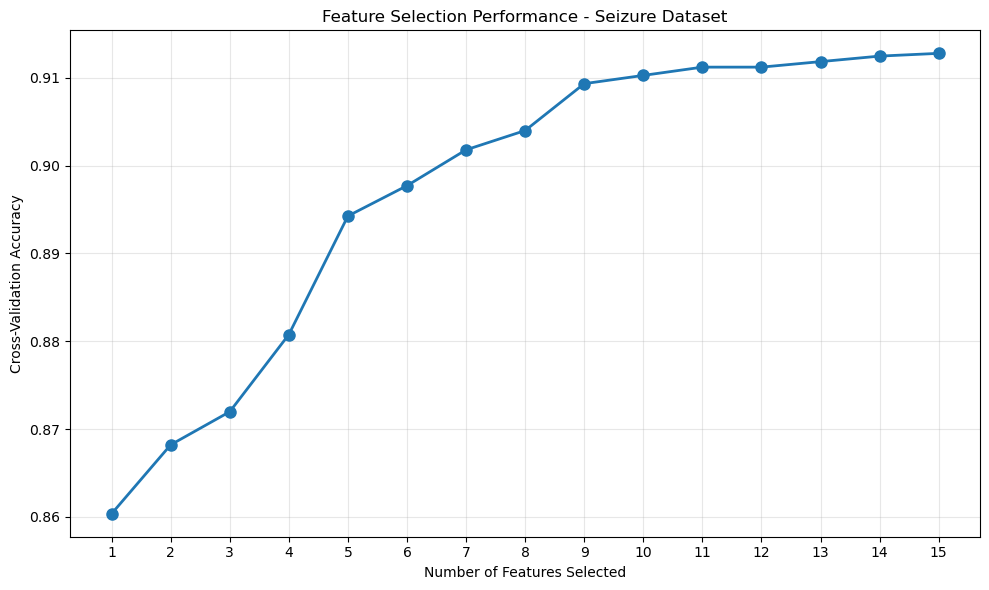


📊 Final Model Performance:
Cross-validated accuracy: 0.912 (+/- 0.019)
Individual fold scores: ['0.900', '0.925', '0.918', '0.914', '0.903']
Baseline (all 50 features): 0.907

🔍 Feature Type Analysis:
  CSP: 2 features
  Wavelet: 10 features
  Other: 3 features


In [6]:
#CELL 6: feature selection 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ------------------------------
# 📌 1. Robust Feature Loader with NaN Handling
# ------------------------------
def load_features(files, base_path=""):
    X_list, y_list, names_list = [], [], []

    for file in files:
        full_path = base_path + file
        if not os.path.exists(full_path):
            print(f"⚠️ File not found: {full_path}")
            continue
            
        data = np.load(full_path)
        keys = data.files

        # Extract data using standard keys
        feat_key = 'x' if 'x' in keys else keys[0]
        label_key = 'y' if 'y' in keys else None
        names_key = 'feature_names' if 'feature_names' in keys else None

        X_data = data[feat_key]
        
        # Check for NaN values
        nan_count = np.isnan(X_data).sum()
        if nan_count > 0:
            print(f"⚠️ {file} contains {nan_count} NaN values")
        
        X_list.append(X_data)
        
        if label_key and label_key in keys:
            y_list.append(data[label_key])
        else:
            # If no labels, create dummy labels (this shouldn't happen with our data)
            print(f"⚠️ No labels found in {file}, using zeros")
            y_list.append(np.zeros(X_data.shape[0]))
            
        if names_key and names_key in keys:
            names_list.append(list(data[names_key]))
        else:
            # If no feature names, create generic names
            num_features = X_data.shape[1]
            names_list.append([f'feature_{i}' for i in range(num_features)])

    # Find common number of samples across all files
    min_samples = min(X.shape[0] for X in X_list)
    
    # Truncate all arrays to the minimum number of samples
    X_truncated = [X[:min_samples] for X in X_list]
    y_truncated = [y[:min_samples] for y in y_list]
    
    # Concatenate features along columns
    X_combined = np.concatenate(X_truncated, axis=1)
    
    # Use labels from first file (they should be consistent)
    y_combined = y_truncated[0]
    
    # Combine feature names
    all_names = []
    for names in names_list:
        all_names.extend(names)
    
    return X_combined, y_combined, all_names

# ------------------------------
# 📌 2. Handle NaN Values and Constant Features
# ------------------------------
def clean_features(X, y, feature_names, nan_threshold=0.1, constant_threshold=0.01):
    """Remove features with too many NaN values and constant features"""
    
    # Step 1: Remove features with too many NaN values
    nan_ratio = np.isnan(X).mean(axis=0)
    bad_nan_features = nan_ratio > nan_threshold
    good_features = ~bad_nan_features
    
    if bad_nan_features.sum() > 0:
        print(f"Removing {bad_nan_features.sum()} features with >{nan_threshold*100}% NaN values")
        X_clean = X[:, good_features]
        feature_names_clean = [feature_names[i] for i in range(len(feature_names)) if good_features[i]]
    else:
        X_clean = X
        feature_names_clean = feature_names
    
    # Step 2: Remove samples with any remaining NaN values
    nan_samples = np.isnan(X_clean).any(axis=1)
    if nan_samples.sum() > 0:
        print(f"Removing {nan_samples.sum()} samples with NaN values")
        X_clean = X_clean[~nan_samples]
        y_clean = y[~nan_samples]
    else:
        y_clean = y
    
    # Step 3: Remove constant features
    feature_stds = np.nanstd(X_clean, axis=0)
    constant_features = feature_stds < constant_threshold
    
    if constant_features.sum() > 0:
        print(f"Removing {constant_features.sum()} constant features")
        non_constant_features = ~constant_features
        X_clean = X_clean[:, non_constant_features]
        feature_names_clean = [feature_names_clean[i] for i in range(len(feature_names_clean)) if non_constant_features[i]]
    
    return X_clean, y_clean, feature_names_clean

# ------------------------------
# 📌 3. Robust Feature Selection
# ------------------------------
def robust_feature_selection(X, y, feature_names, n_features=20):
    """Perform feature selection with robust handling of data issues"""
    
    # Handle any remaining NaN values with imputation
    if np.isnan(X).any():
        print("Imputing remaining NaN values...")
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Use mutual information for initial feature selection (more robust than ANOVA)
    from sklearn.feature_selection import mutual_info_classif
    
    print("Calculating mutual information scores...")
    mi_scores = mutual_info_classif(X_scaled, y, random_state=42, n_neighbors=5)
    
    # Select top features based on mutual information
    n_pre_select = min(50, X_scaled.shape[1])
    top_indices = np.argsort(mi_scores)[-n_pre_select:][::-1]
    
    X_reduced = X_scaled[:, top_indices]
    feature_names_reduced = [feature_names[i] for i in top_indices]
    mi_scores_reduced = mi_scores[top_indices]
    
    print(f"Pre-selected {n_pre_select} features using mutual information")
    
    return X_reduced, feature_names_reduced, mi_scores_reduced

# ------------------------------
# 📌 4. Main Execution
# ------------------------------
base_path = "../data/processed/mit_chb/"

# List all feature files
all_files = [f for f in os.listdir(base_path) if f.endswith('.npz') and any(prefix in f for prefix in ['features_', 'simple_features_', 'discriminant_features_'])]

print("Available feature files:")
for f in all_files:
    print(f"  - {f}")

# Group by dataset type
predictive_files = [f for f in all_files if 'predictive' in f and 'train' in f]
predictive_files += [f for f in all_files if 'predictive' in f and 'val' in f]

seizure_files = [f for f in all_files if 'seizure' in f and 'train' in f]
seizure_files += [f for f in all_files if 'seizure' in f and 'val' in f]

print(f"\nPredictive files: {len(predictive_files)} files")
print(f"Seizure files: {len(seizure_files)} files")

# ------------------------------
# 📌 5. Load and Clean Data
# ------------------------------
if seizure_files:
    X_seizure, y_seizure, names_seizure = load_features(seizure_files, base_path)
    print(f"Raw seizure features: {X_seizure.shape}, labels: {y_seizure.shape}")
    
    # Clean NaN values and constant features
    X_seizure, y_seizure, names_seizure = clean_features(X_seizure, y_seizure, names_seizure)
    print(f"Clean seizure features: {X_seizure.shape}, labels: {y_seizure.shape}")

if predictive_files:
    X_predictive, y_predictive, names_predictive = load_features(predictive_files, base_path)
    print(f"Raw predictive features: {X_predictive.shape}, labels: {y_predictive.shape}")
    
    # Clean NaN values and constant features
    X_predictive, y_predictive, names_predictive = clean_features(X_predictive, y_predictive, names_predictive)
    print(f"Clean predictive features: {X_predictive.shape}, labels: {y_predictive.shape}")

# ------------------------------
# 📌 6. Choose Which Dataset to Analyze
# ------------------------------
# Let's analyze the seizure dataset (usually more interesting for classification)
if 'X_seizure' in locals() and X_seizure.shape[0] > 0:
    X = X_seizure
    y = y_seizure
    feature_names = names_seizure
    dataset_name = "Seizure"
elif 'X_predictive' in locals() and X_predictive.shape[0] > 0:
    X = X_predictive
    y = y_predictive
    feature_names = names_predictive
    dataset_name = "Predictive"
else:
    raise ValueError("No valid feature files found!")

print(f"\nAnalyzing {dataset_name} dataset:")
print(f"Feature matrix: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Label distribution: {np.unique(y, return_counts=True)}")

# ------------------------------
# 📌 7. Robust Feature Selection
# ------------------------------
print("\nPerforming robust feature selection...")

# Use mutual information for robust feature pre-selection
X_reduced, feature_names_reduced, mi_scores = robust_feature_selection(X, y, feature_names, n_features=20)

print(f"Reduced to {X_reduced.shape[1]} features for final selection")

# ------------------------------
# 📌 8. Sequential Feature Selection on Cleaned Data
# ------------------------------
estimator = KNeighborsClassifier(n_neighbors=5)  # Increased neighbors for stability

n_features_to_select = min(15, X_reduced.shape[1])

print(f"Performing sequential feature selection on {X_reduced.shape[1]} features...")
print(f"Target: select {n_features_to_select} best features")

try:
    sfs = SequentialFeatureSelector(
        estimator,
        n_features_to_select=n_features_to_select,
        direction='forward',
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )

    sfs.fit(X_reduced, y)
    selected_indices = sfs.get_support()
    selected_features = np.array(feature_names_reduced)[selected_indices]
    
    # Get the mutual information scores for selected features
    selected_mi_scores = mi_scores[selected_indices]

    print(f"\n✅ Selected {len(selected_features)} features:")
    for i, (feature, mi_score) in enumerate(zip(selected_features, selected_mi_scores)):
        print(f"  {i+1:2d}. {feature} (MI: {mi_score:.4f})")

    # ------------------------------
    # 📌 9. Plot Accuracy vs Number of Features
    # ------------------------------
    accuracy_list = []
    feature_numbers = list(range(1, n_features_to_select + 1))

    print(f"\nEvaluating performance with different numbers of features...")

    for n in feature_numbers:
        sfs_tmp = SequentialFeatureSelector(
            estimator,
            n_features_to_select=n,
            direction='forward',
            scoring='accuracy',
            cv=3,
            n_jobs=-1
        )
        sfs_tmp.fit(X_reduced, y)
        X_selected = X_reduced[:, sfs_tmp.get_support()]
        acc = cross_val_score(estimator, X_selected, y, cv=3).mean()
        accuracy_list.append(acc)
        print(f"  Features: {n}, Accuracy: {acc:.3f}")

    plt.figure(figsize=(10, 6))
    plt.plot(feature_numbers, accuracy_list, marker='o', linewidth=2, markersize=8)
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title(f"Feature Selection Performance - {dataset_name} Dataset")
    plt.grid(True, alpha=0.3)
    plt.xticks(feature_numbers)
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 📌 10. Final Model Performance
    # ------------------------------
    print("\n📊 Final Model Performance:")
    X_final = X_reduced[:, selected_indices]
    final_scores = cross_val_score(estimator, X_final, y, cv=5)
    print(f"Cross-validated accuracy: {final_scores.mean():.3f} (+/- {final_scores.std() * 2:.3f})")
    print(f"Individual fold scores: {[f'{score:.3f}' for score in final_scores]}")
    
    # Baseline performance with all features
    baseline_scores = cross_val_score(estimator, X_reduced, y, cv=5)
    print(f"Baseline (all {X_reduced.shape[1]} features): {baseline_scores.mean():.3f}")

except Exception as e:
    print(f"❌ Error in sequential feature selection: {e}")
    print("Using mutual information ranking instead...")
    
    # Fallback: use mutual information ranking
    top_indices = np.argsort(mi_scores)[-n_features_to_select:][::-1]
    selected_features = np.array(feature_names_reduced)[top_indices]
    selected_mi_scores = mi_scores[top_indices]
    
    print(f"Selected {len(selected_features)} features using mutual information:")
    for i, (feature, mi_score) in enumerate(zip(selected_features, selected_mi_scores)):
        print(f"  {i+1:2d}. {feature} (MI: {mi_score:.4f})")
    
    # Evaluate performance
    X_final = X_reduced[:, top_indices]
    final_scores = cross_val_score(estimator, X_final, y, cv=5)
    print(f"Cross-validated accuracy: {final_scores.mean():.3f} (+/- {final_scores.std() * 2:.3f})")

# ------------------------------
# 📌 11. Feature Type Analysis
# ------------------------------
print(f"\n🔍 Feature Type Analysis:")
feature_types = {}
for feature in selected_features:
    if 'ch' in feature and 'w' in feature:
        feature_types['Wavelet'] = feature_types.get('Wavelet', 0) + 1
    elif 'csp' in feature:
        feature_types['CSP'] = feature_types.get('CSP', 0) + 1
    elif 'mean_amp' in feature or 'line_length' in feature or 'zcr' in feature:
        feature_types['Time Domain'] = feature_types.get('Time Domain', 0) + 1
    elif 'mean_freq' in feature or 'peak_freq' in feature or 'bandwidth' in feature:
        feature_types['Frequency Domain'] = feature_types.get('Frequency Domain', 0) + 1
    elif 'power' in feature:
        feature_types['Power'] = feature_types.get('Power', 0) + 1
    else:
        feature_types['Other'] = feature_types.get('Other', 0) + 1

for feature_type, count in feature_types.items():
    print(f"  {feature_type}: {count} features")

🔵 SVM Classification Analysis
SVM Test Accuracy: 0.8830
SVM Precision: 0.8781
SVM Recall: 0.8830
SVM F1-Score: 0.8693
SVM Cross-validation Accuracy: 0.8921 (+/- 0.0146)


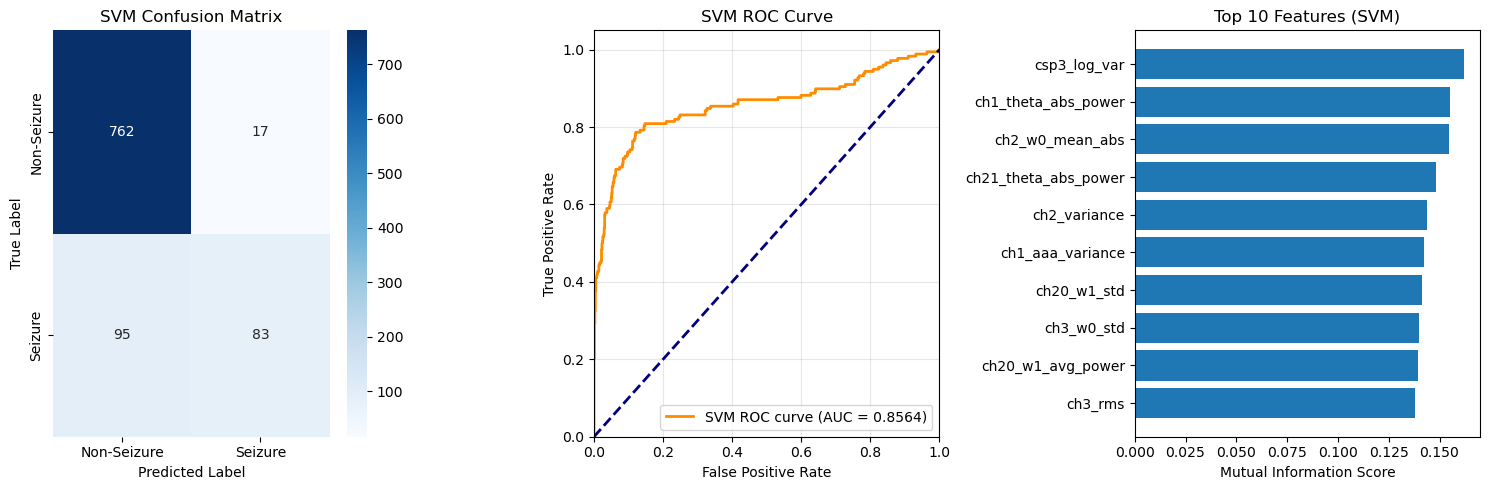

✅ SVM analysis complete!


In [7]:
# CELL 7: Classification with SVM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import os

# Create results directory if it doesn't exist
results_dir = "../results/figures/"
os.makedirs(results_dir, exist_ok=True)

print("🔵 SVM Classification Analysis")
print("=" * 50)

# Use the final selected features from previous cell
X_final_svm = X_reduced[:, selected_indices]
y_svm = y

# Split the data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_final_svm, y_svm, test_size=0.3, random_state=42, stratify=y_svm
)

# Scale the features (important for SVM)
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm)
X_test_svm_scaled = scaler_svm.transform(X_test_svm)

# Train SVM with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42, probability=True, C=1.0, gamma='scale')
svm_model.fit(X_train_svm_scaled, y_train_svm)

# Predictions
y_pred_svm = svm_model.predict(X_test_svm_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_svm_scaled)[:, 1]

# Calculate metrics
svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)
svm_precision = precision_score(y_test_svm, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test_svm, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test_svm, y_pred_svm, average='weighted')

# Cross-validation
cv_scores_svm = cross_val_score(svm_model, X_final_svm, y_svm, cv=5, scoring='accuracy')

print(f"SVM Test Accuracy: {svm_accuracy:.4f}")
print(f"SVM Precision: {svm_precision:.4f}")
print(f"SVM Recall: {svm_recall:.4f}")
print(f"SVM F1-Score: {svm_f1:.4f}")
print(f"SVM Cross-validation Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Seizure', 'Seizure'], 
            yticklabels=['Non-Seizure', 'Seizure'])
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr_svm, tpr_svm, _ = roc_curve(y_test_svm, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, 
         label=f'SVM ROC curve (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Feature Importance (using coefficients for linear SVM approximation)
plt.subplot(1, 3, 3)
# For RBF kernel, we'll show the selected features and their MI scores
feature_importance_svm = selected_mi_scores
indices = np.argsort(feature_importance_svm)[-10:]  # Top 10 features
plt.barh(range(len(indices)), feature_importance_svm[indices])
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Mutual Information Score')
plt.title('Top 10 Features (SVM)')
plt.tight_layout()

plt.savefig(f"{results_dir}svm_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Store SVM results for comparison
svm_results = {
    'model_name': 'SVM',
    'accuracy': svm_accuracy,
    'precision': svm_precision,
    'recall': svm_recall,
    'f1_score': svm_f1,
    'cv_mean': cv_scores_svm.mean(),
    'cv_std': cv_scores_svm.std(),
    'roc_auc': roc_auc_svm,
    'y_test': y_test_svm,
    'y_pred': y_pred_svm,
    'y_pred_proba': y_pred_proba_svm
}

print("✅ SVM analysis complete!")


In [8]:
# COMPREHENSIVE PATH CORRECTION
import os
import numpy as np

print("🔧 COMPREHENSIVE PATH CORRECTION")
print("=" * 50)

# Define correct paths from notebook directory
paths = {
    'raw_data': "../data/raw/",
    'processed_data': "../data/processed/mit_chb/",
    'results': "../results/figures/"
}

# Verify all paths exist
print("📁 Verifying paths:")
for name, path in paths.items():
    exists = os.path.exists(path)
    print(f"  {name:15}: {path:30} {'✅' if exists else '❌'}")

# Set correct base paths for different operations
raw_base_path = paths['raw_data']
processed_base_path = paths['processed_data']
results_dir = paths['results']

# Create results directory if needed
os.makedirs(results_dir, exist_ok=True)

print("✅ Path correction complete!")
print(f"Raw data path: {raw_base_path}")
print(f"Processed data path: {processed_base_path}")
print(f"Results path: {results_dir}")


🔧 COMPREHENSIVE PATH CORRECTION
📁 Verifying paths:
  raw_data       : ../data/raw/                   ✅
  processed_data : ../data/processed/mit_chb/     ✅
  results        : ../results/figures/            ✅
✅ Path correction complete!
Raw data path: ../data/raw/
Processed data path: ../data/processed/mit_chb/
Results path: ../results/figures/


🟢 KNN Classification Analysis
Performing hyperparameter tuning for KNN...
Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.9067
KNN Test Accuracy: 0.9007
KNN Precision: 0.8958
KNN Recall: 0.9007
KNN F1-Score: 0.8955
KNN Cross-validation Accuracy: 0.9118 (+/- 0.0174)


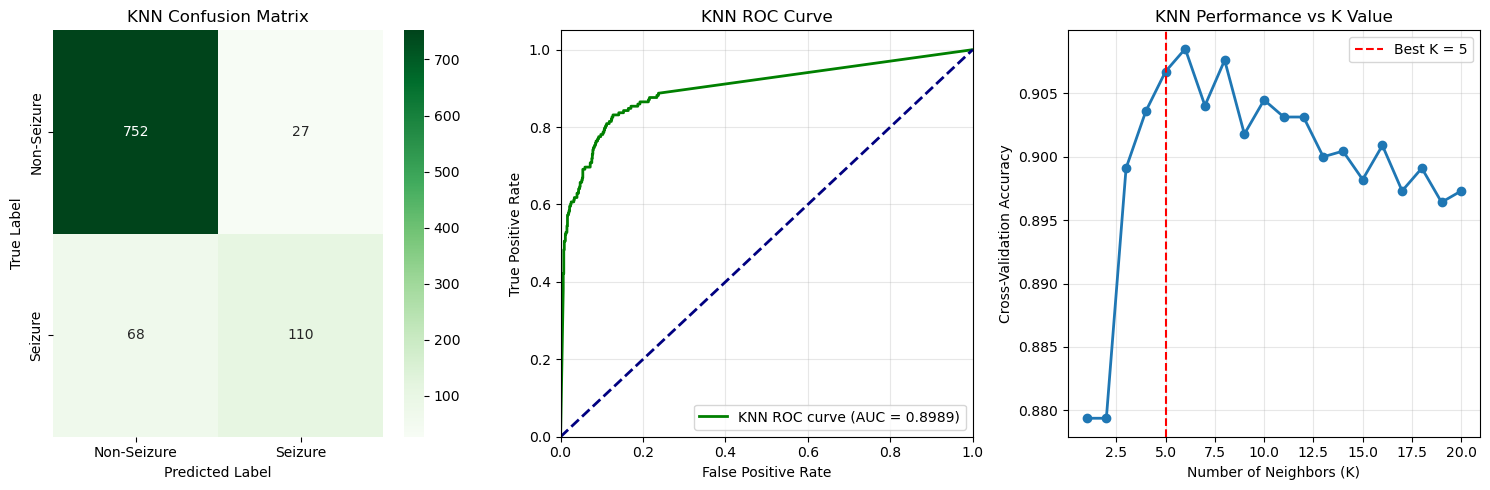

✅ KNN analysis complete!


In [9]:
# CELL 8: Classification with K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

print("🟢 KNN Classification Analysis")
print("=" * 50)

# Use the same data split as SVM for fair comparison
X_final_knn = X_reduced[:, selected_indices]
y_knn = y

# Split the data (using same random state for consistency)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_final_knn, y_knn, test_size=0.3, random_state=42, stratify=y_knn
)

# Scale the features (good practice for KNN)
scaler_knn = StandardScaler()
X_train_knn_scaled = scaler_knn.fit_transform(X_train_knn)
X_test_knn_scaled = scaler_knn.transform(X_test_knn)

# Hyperparameter tuning for KNN
print("Performing hyperparameter tuning for KNN...")
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

knn_grid.fit(X_train_knn_scaled, y_train_knn)
best_knn = knn_grid.best_estimator_

print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

# Train the best KNN model
knn_model = best_knn
knn_model.fit(X_train_knn_scaled, y_train_knn)

# Predictions
y_pred_knn = knn_model.predict(X_test_knn_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_knn_scaled)[:, 1]

# Calculate metrics
knn_accuracy = accuracy_score(y_test_knn, y_pred_knn)
knn_precision = precision_score(y_test_knn, y_pred_knn, average='weighted')
knn_recall = recall_score(y_test_knn, y_pred_knn, average='weighted')
knn_f1 = f1_score(y_test_knn, y_pred_knn, average='weighted')

# Cross-validation with best model
cv_scores_knn = cross_val_score(knn_model, X_final_knn, y_knn, cv=5, scoring='accuracy')

print(f"KNN Test Accuracy: {knn_accuracy:.4f}")
print(f"KNN Precision: {knn_precision:.4f}")
print(f"KNN Recall: {knn_recall:.4f}")
print(f"KNN F1-Score: {knn_f1:.4f}")
print(f"KNN Cross-validation Accuracy: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std() * 2:.4f})")

# Visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Non-Seizure', 'Seizure'], 
            yticklabels=['Non-Seizure', 'Seizure'])
plt.title('KNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr_knn, tpr_knn, _ = roc_curve(y_test_knn, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, 
         label=f'KNN ROC curve (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# K-value performance analysis
plt.subplot(1, 3, 3)
k_values = range(1, 21)
k_scores = []
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn_temp, X_train_knn_scaled, y_train_knn, cv=5)
    k_scores.append(scores.mean())

plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=6)
plt.axvline(x=knn_grid.best_params_['n_neighbors'], color='red', linestyle='--', 
            label=f"Best K = {knn_grid.best_params_['n_neighbors']}")
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Performance vs K Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f"{results_dir}knn_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Store KNN results for comparison
knn_results = {
    'model_name': 'KNN',
    'accuracy': knn_accuracy,
    'precision': knn_precision,
    'recall': knn_recall,
    'f1_score': knn_f1,
    'cv_mean': cv_scores_knn.mean(),
    'cv_std': cv_scores_knn.std(),
    'roc_auc': roc_auc_knn,
    'best_params': knn_grid.best_params_,
    'y_test': y_test_knn,
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn
}

print("✅ KNN analysis complete!")


🟠 Random Forest Classification Analysis
Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9112
Random Forest Test Accuracy: 0.9143
Random Forest Precision: 0.9138
Random Forest Recall: 0.9143
Random Forest F1-Score: 0.9072
Random Forest Cross-validation Accuracy: 0.9156 (+/- 0.0176)


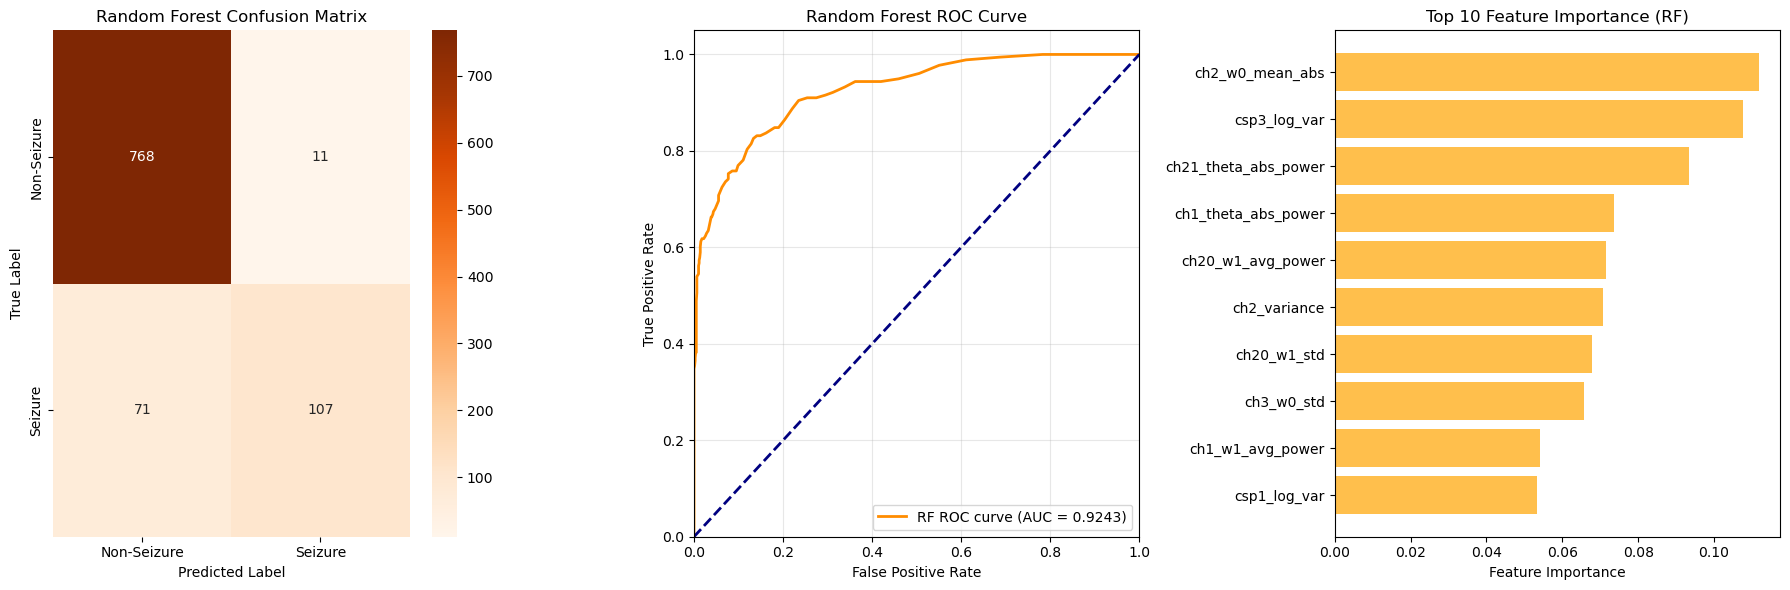

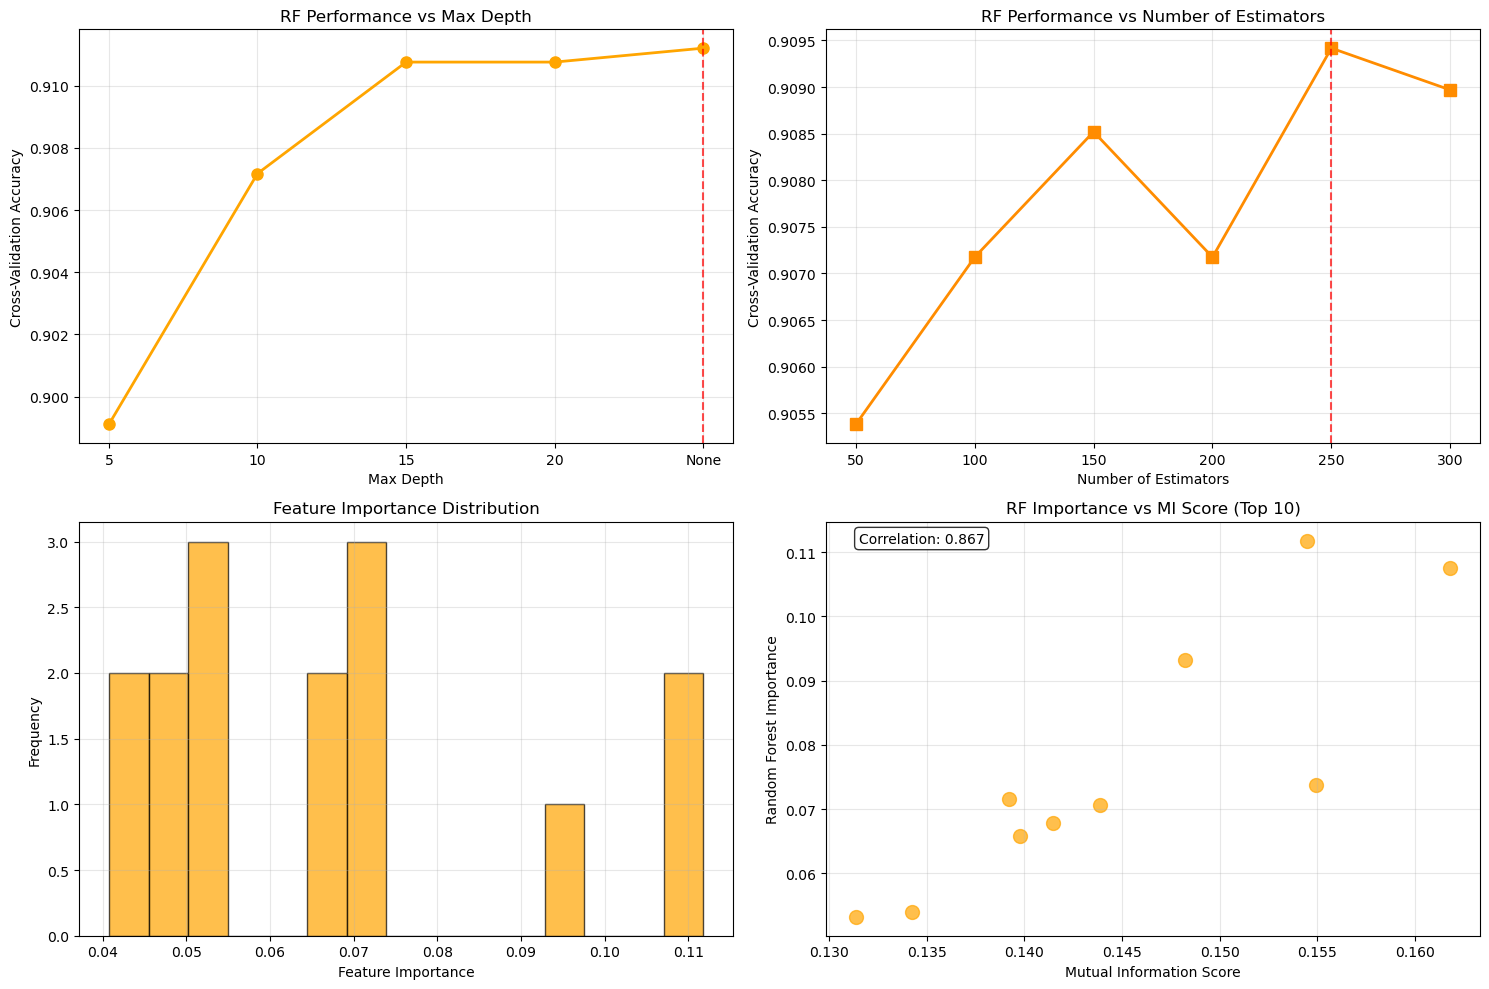

✅ Random Forest analysis complete!
Results saved to: ../results/figures/random_forest_analysis.png
Hyperparameter analysis saved to: ../results/figures/random_forest_hyperparameters.png


In [10]:
# CELL 9: Classification with Random Forest 🟠
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🟠 Random Forest Classification Analysis")
print("=" * 50)

# Use the same data split as SVM and KNN for fair comparison
X_final_rf = X_reduced[:, selected_indices]
y_rf = y

# Split the data (using same random state for consistency)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_final_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf
)

# Scale the features (good practice, though RF is less sensitive)
scaler_rf = StandardScaler()
X_train_rf_scaled = scaler_rf.fit_transform(X_train_rf)
X_test_rf_scaled = scaler_rf.transform(X_test_rf)

# Hyperparameter tuning for Random Forest
print("Performing hyperparameter tuning for Random Forest...")
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_rf_scaled, y_train_rf)
best_rf = rf_grid.best_estimator_

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Train the best Random Forest model
rf_model = best_rf
rf_model.fit(X_train_rf_scaled, y_train_rf)

# Predictions
y_pred_rf = rf_model.predict(X_test_rf_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_rf_scaled)[:, 1]

# Calculate metrics
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
rf_precision = precision_score(y_test_rf, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test_rf, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test_rf, y_pred_rf, average='weighted')

# Cross-validation with best model
cv_scores_rf = cross_val_score(rf_model, X_final_rf, y_rf, cv=5, scoring='accuracy')

print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest F1-Score: {rf_f1:.4f}")
print(f"Random Forest Cross-validation Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Get feature importance
feature_importance = rf_model.feature_importances_
feature_names_selected = [selected_features[i] for i in range(len(selected_features))]

# Main visualizations
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Non-Seizure', 'Seizure'], 
            yticklabels=['Non-Seizure', 'Seizure'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, 
         label=f'RF ROC curve (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Feature Importance (Top 10)
plt.subplot(1, 3, 3)
indices = np.argsort(feature_importance)[-10:]  # Top 10 features
plt.barh(range(len(indices)), feature_importance[indices], color='orange', alpha=0.7)
plt.yticks(range(len(indices)), [feature_names_selected[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance (RF)')
plt.tight_layout()

plt.savefig(f"{results_dir}random_forest_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Hyperparameter Analysis
plt.figure(figsize=(15, 10))

# Max Depth Analysis
plt.subplot(2, 2, 1)
max_depths = [5, 10, 15, 20, None]
depth_scores = []
for depth in max_depths:
    rf_temp = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    scores = cross_val_score(rf_temp, X_train_rf_scaled, y_train_rf, cv=5)
    depth_scores.append(scores.mean())

depth_labels = [str(d) if d is not None else 'None' for d in max_depths]
plt.plot(depth_labels, depth_scores, marker='o', linewidth=2, markersize=8, color='orange')
best_depth_idx = np.argmax(depth_scores)
plt.axvline(x=best_depth_idx, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('RF Performance vs Max Depth')
plt.grid(True, alpha=0.3)

# Number of Estimators Analysis
plt.subplot(2, 2, 2)
n_estimators_range = [50, 100, 150, 200, 250, 300]
estimator_scores = []
for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=42)
    scores = cross_val_score(rf_temp, X_train_rf_scaled, y_train_rf, cv=5)
    estimator_scores.append(scores.mean())

plt.plot(n_estimators_range, estimator_scores, marker='s', linewidth=2, markersize=8, color='darkorange')
best_est_idx = np.argmax(estimator_scores)
plt.axvline(x=n_estimators_range[best_est_idx], color='red', linestyle='--', alpha=0.7)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Accuracy')
plt.title('RF Performance vs Number of Estimators')
plt.grid(True, alpha=0.3)

# Feature Importance Distribution
plt.subplot(2, 2, 3)
plt.hist(feature_importance, bins=15, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('Feature Importance Distribution')
plt.grid(True, alpha=0.3)

# Top Features Comparison with MI Scores
plt.subplot(2, 2, 4)
# Get top 10 features by RF importance
top_rf_indices = np.argsort(feature_importance)[-10:]
rf_importance_top = feature_importance[top_rf_indices]
mi_scores_top = selected_mi_scores[top_rf_indices]

plt.scatter(mi_scores_top, rf_importance_top, alpha=0.7, s=100, color='orange')
plt.xlabel('Mutual Information Score')
plt.ylabel('Random Forest Importance')
plt.title('RF Importance vs MI Score (Top 10)')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(mi_scores_top, rf_importance_top)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f"{results_dir}random_forest_hyperparameters.png", dpi=300, bbox_inches='tight')
plt.show()

# Store Random Forest results for comparison
rf_results = {
    'model_name': 'Random Forest',
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'cv_mean': cv_scores_rf.mean(),
    'cv_std': cv_scores_rf.std(),
    'roc_auc': roc_auc_rf,
    'best_params': rf_grid.best_params_,
    'feature_importance': feature_importance,
    'y_test': y_test_rf,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}

print("✅ Random Forest analysis complete!")
print(f"Results saved to: {results_dir}random_forest_analysis.png")
print(f"Hyperparameter analysis saved to: {results_dir}random_forest_hyperparameters.png")


🏆 Comprehensive Model Comparison & Statistical Analysis
📊 Performance Summary:
           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV_Mean  \
0            SVM    0.8830     0.8781  0.8830    0.8693   0.8564   0.8921   
1            KNN    0.9007     0.8958  0.9007    0.8955   0.8989   0.9118   
2  Random Forest    0.9143     0.9138  0.9143    0.9072   0.9243   0.9156   

   CV_Std  
0  0.0073  
1  0.0087  
2  0.0088  

🔬 Statistical Significance Testing (McNemar's Test):
--------------------------------------------------
SVM vs KNN: p-value = 0.0280 (Significant)
SVM vs Random Forest: p-value = 0.0000 (Significant)
KNN vs Random Forest: p-value = 0.0993 (Not Significant)


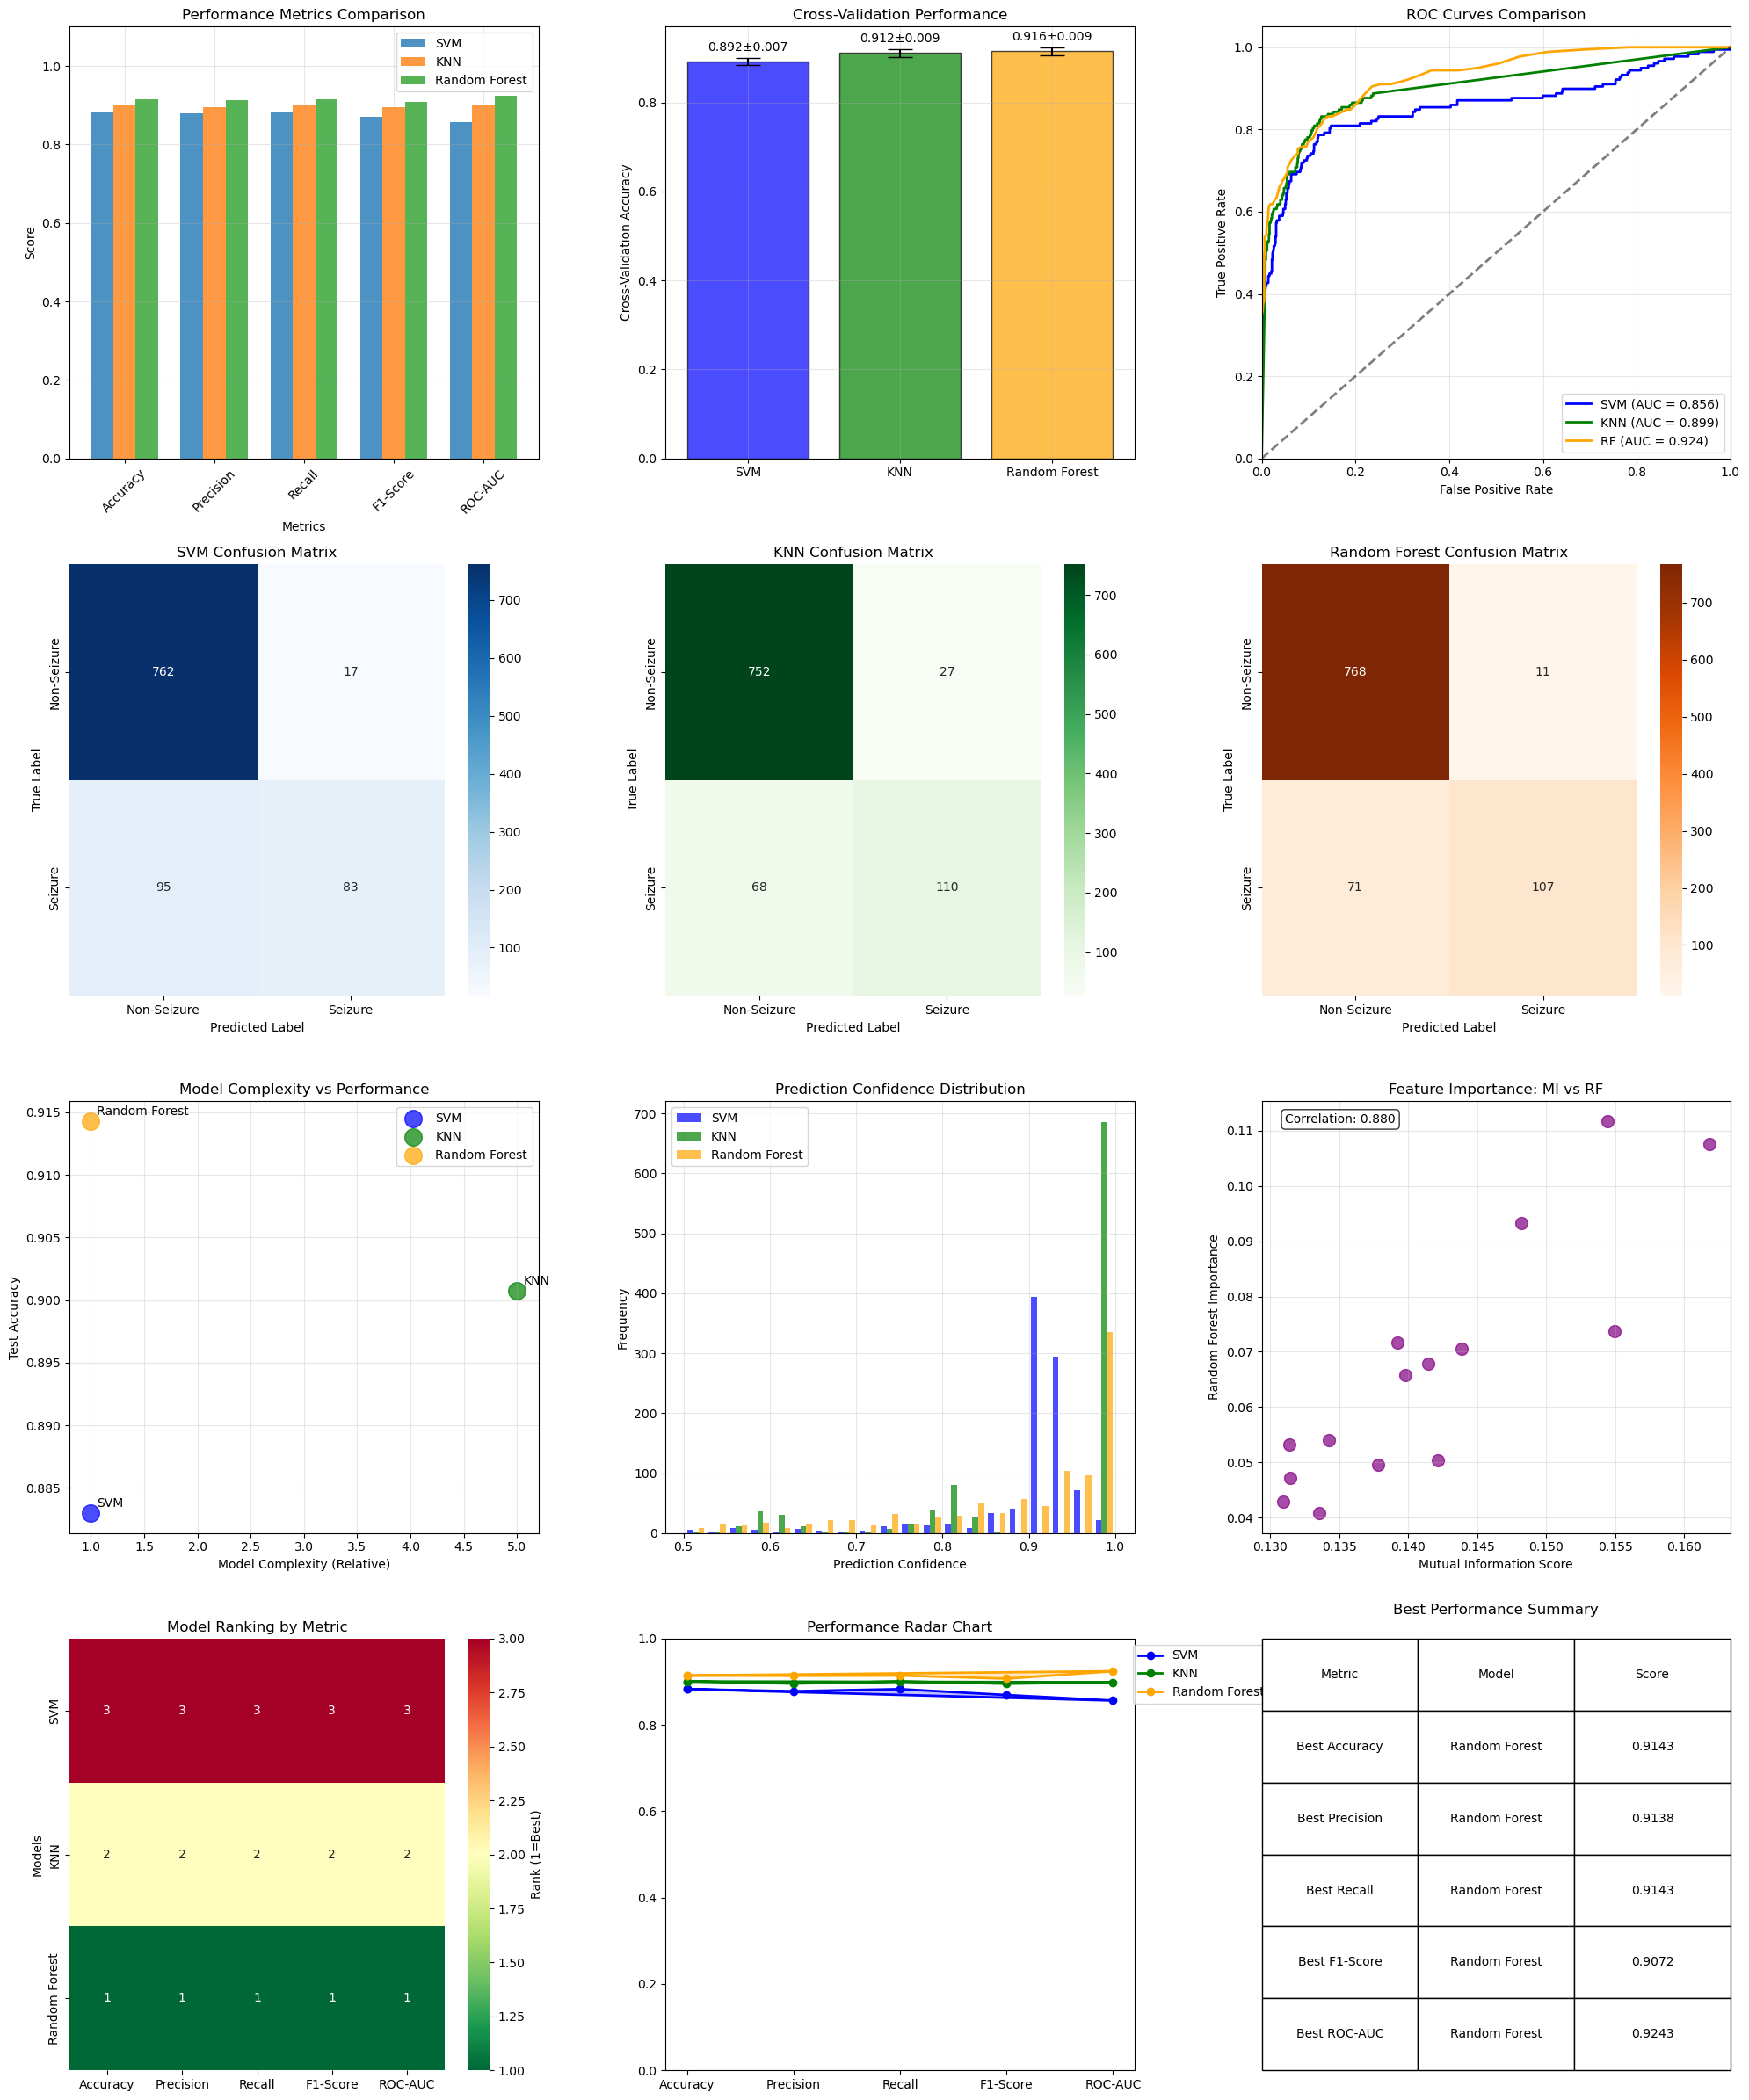


🎯 Final Model Recommendations:
🏆 Best Overall Model: Random Forest
   F1-Score: 0.9072
   Accuracy: 0.9143
   ROC-AUC: 0.9243

📈 Highest Accuracy: Random Forest (0.9143)
🎯 Highest Precision: Random Forest (0.9138)
🔍 Highest Recall: Random Forest (0.9143)
📊 Highest ROC-AUC: Random Forest (0.9243)

💾 Results saved to:
   📊 Comprehensive analysis: ../results/figures/comprehensive_model_comparison.png
   📋 Detailed results: ../results/figures/model_comparison_results.csv

✅ Comprehensive model comparison complete!
🎉 All classification analyses finished successfully!


In [12]:
# CELL 10: Comprehensive Model Comparison 🏆
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

print("🏆 Comprehensive Model Comparison & Statistical Analysis")
print("=" * 70)

# Compile all results
all_results = [svm_results, knn_results, rf_results]
model_names = ['SVM', 'KNN', 'Random Forest']

# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Model': [result['model_name'] for result in all_results],
    'Accuracy': [result['accuracy'] for result in all_results],
    'Precision': [result['precision'] for result in all_results],
    'Recall': [result['recall'] for result in all_results],
    'F1-Score': [result['f1_score'] for result in all_results],
    'ROC-AUC': [result['roc_auc'] for result in all_results],
    'CV_Mean': [result['cv_mean'] for result in all_results],
    'CV_Std': [result['cv_std'] for result in all_results]
})

print("📊 Performance Summary:")
print(results_df.round(4))

# Statistical Significance Testing (McNemar's Test)
print("\n🔬 Statistical Significance Testing (McNemar's Test):")
print("-" * 50)

models_data = [(svm_results, 'SVM'), (knn_results, 'KNN'), (rf_results, 'Random Forest')]
mcnemar_results = {}

for i in range(len(models_data)):
    for j in range(i+1, len(models_data)):
        model1_data, model1_name = models_data[i]
        model2_data, model2_name = models_data[j]
        
        # Create contingency table for McNemar's test
        y_true = model1_data['y_test']  # Same for all models
        pred1 = model1_data['y_pred']
        pred2 = model2_data['y_pred']
        
        # McNemar's test contingency table
        correct1_correct2 = np.sum((pred1 == y_true) & (pred2 == y_true))
        correct1_wrong2 = np.sum((pred1 == y_true) & (pred2 != y_true))
        wrong1_correct2 = np.sum((pred1 != y_true) & (pred2 == y_true))
        wrong1_wrong2 = np.sum((pred1 != y_true) & (pred2 != y_true))
        
        contingency_table = np.array([[correct1_correct2, correct1_wrong2],
                                     [wrong1_correct2, wrong1_wrong2]])
        
        # Perform McNemar's test
        try:
            result = mcnemar(contingency_table, exact=False, correction=True)
            p_value = result.pvalue
            mcnemar_results[f"{model1_name} vs {model2_name}"] = p_value
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            print(f"{model1_name} vs {model2_name}: p-value = {p_value:.4f} ({significance})")
        except:
            print(f"{model1_name} vs {model2_name}: Unable to compute McNemar's test")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 24))

# 1. Performance Metrics Bar Chart
plt.subplot(4, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(model_names):
    values = [results_df.iloc[i][metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

# 2. Cross-Validation Performance with Error Bars
plt.subplot(4, 3, 2)
cv_means = [result['cv_mean'] for result in all_results]
cv_stds = [result['cv_std'] for result in all_results]
colors = ['blue', 'green', 'orange']

bars = plt.bar(model_names, cv_means, yerr=cv_stds, capsize=10, 
               color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Performance')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, cv_means, cv_stds):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom')

# 3. ROC Curves Comparison
plt.subplot(4, 3, 3)
# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(svm_results['y_test'], svm_results['y_pred_proba'])
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, 
         label=f'SVM (AUC = {svm_results["roc_auc"]:.3f})')

# KNN ROC
fpr_knn, tpr_knn, _ = roc_curve(knn_results['y_test'], knn_results['y_pred_proba'])
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, 
         label=f'KNN (AUC = {knn_results["roc_auc"]:.3f})')

# RF ROC
fpr_rf, tpr_rf, _ = roc_curve(rf_results['y_test'], rf_results['y_pred_proba'])
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, 
         label=f'RF (AUC = {rf_results["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 4-6. Confusion Matrices Comparison
confusion_matrices = [
    (confusion_matrix(svm_results['y_test'], svm_results['y_pred']), 'SVM', 'Blues'),
    (confusion_matrix(knn_results['y_test'], knn_results['y_pred']), 'KNN', 'Greens'),
    (confusion_matrix(rf_results['y_test'], rf_results['y_pred']), 'Random Forest', 'Oranges')
]

for i, (cm, name, cmap) in enumerate(confusion_matrices):
    plt.subplot(4, 3, 4 + i)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=['Non-Seizure', 'Seizure'], 
                yticklabels=['Non-Seizure', 'Seizure'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# 7. Model Complexity vs Performance
plt.subplot(4, 3, 7)
# Extract complexity measures (simplified)
complexity_measures = [
    1,  # SVM - relatively simple with RBF kernel
    knn_results['best_params']['n_neighbors'],  # KNN - number of neighbors
    rf_results['best_params']['n_estimators'] / 100  # RF - scaled number of estimators
]

accuracies = [result['accuracy'] for result in all_results]
colors_scatter = ['blue', 'green', 'orange']

for i, (complexity, accuracy, model, color) in enumerate(zip(complexity_measures, accuracies, model_names, colors_scatter)):
    plt.scatter(complexity, accuracy, s=200, alpha=0.7, color=color, label=model)
    plt.annotate(model, (complexity, accuracy), xytext=(5, 5), 
                textcoords='offset points', fontsize=10)

plt.xlabel('Model Complexity (Relative)')
plt.ylabel('Test Accuracy')
plt.title('Model Complexity vs Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Prediction Confidence Distribution
plt.subplot(4, 3, 8)
confidence_data = [
    np.max(svm_model.predict_proba(scaler_svm.transform(X_test_svm)), axis=1),
    np.max(knn_model.predict_proba(scaler_knn.transform(X_test_knn)), axis=1),
    np.max(rf_model.predict_proba(scaler_rf.transform(X_test_rf)), axis=1)
]

plt.hist(confidence_data, bins=20, alpha=0.7, label=model_names, color=colors)
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Feature Importance: MI vs RF
plt.subplot(4, 3, 9)
plt.scatter(selected_mi_scores, rf_results['feature_importance'], 
           alpha=0.7, s=100, color='purple')
plt.xlabel('Mutual Information Score')
plt.ylabel('Random Forest Importance')
plt.title('Feature Importance: MI vs RF')
plt.grid(True, alpha=0.3)

# Add correlation
correlation = np.corrcoef(selected_mi_scores, rf_results['feature_importance'])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 10. Model Ranking by Metric
plt.subplot(4, 3, 10)
ranking_data = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].set_index('Model')
ranking_normalized = ranking_data.rank(ascending=False)

sns.heatmap(ranking_normalized, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Rank (1=Best)'})
plt.title('Model Ranking by Metric')
plt.ylabel('Models')

# 11. Performance Radar Chart
plt.subplot(4, 3, 11)
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

for i, model in enumerate(model_names):
    values = [results_df.iloc[i][cat] for cat in categories]
    values += values[:1]  # Complete the circle
    
    plt.polar(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    plt.fill(angles, values, alpha=0.25, color=colors[i])

plt.xticks(angles[:-1], categories)
plt.ylim(0, 1)
plt.title('Performance Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 12. Summary Statistics Table
plt.subplot(4, 3, 12)
plt.axis('tight')
plt.axis('off')

# Create summary table
summary_stats = pd.DataFrame({
    'Metric': ['Best Accuracy', 'Best Precision', 'Best Recall', 'Best F1-Score', 'Best ROC-AUC'],
    'Model': [
        results_df.loc[results_df['Accuracy'].idxmax(), 'Model'],
        results_df.loc[results_df['Precision'].idxmax(), 'Model'],
        results_df.loc[results_df['Recall'].idxmax(), 'Model'],
        results_df.loc[results_df['F1-Score'].idxmax(), 'Model'],
        results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
    ],
    'Score': [
        f"{results_df['Accuracy'].max():.4f}",
        f"{results_df['Precision'].max():.4f}",
        f"{results_df['Recall'].max():.4f}",
        f"{results_df['F1-Score'].max():.4f}",
        f"{results_df['ROC-AUC'].max():.4f}"
    ]
})

table = plt.table(cellText=summary_stats.values, colLabels=summary_stats.columns,
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Best Performance Summary', pad=20)

plt.tight_layout()
plt.savefig(f"{results_dir}comprehensive_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Save detailed results to CSV
results_df.to_csv(f"{results_dir}model_comparison_results.csv", index=False)

# Print final recommendations
print("\n🎯 Final Model Recommendations:")
print("=" * 50)

best_overall = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"🏆 Best Overall Model: {best_overall['Model']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")

print(f"\n📈 Highest Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} ({results_df['Accuracy'].max():.4f})")
print(f"🎯 Highest Precision: {results_df.loc[results_df['Precision'].idxmax(), 'Model']} ({results_df['Precision'].max():.4f})")
print(f"🔍 Highest Recall: {results_df.loc[results_df['Recall'].idxmax(), 'Model']} ({results_df['Recall'].max():.4f})")
print(f"📊 Highest ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']} ({results_df['ROC-AUC'].max():.4f})")

print(f"\n💾 Results saved to:")
print(f"   📊 Comprehensive analysis: {results_dir}comprehensive_model_comparison.png")
print(f"   📋 Detailed results: {results_dir}model_comparison_results.csv")

print("\n✅ Comprehensive model comparison complete!")
print("🎉 All classification analyses finished successfully!")
